# Initial code

In [1]:
import os
import sys
import re

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA

sys.path.append(os.path.abspath("/home/dferri/ipremom/model/v45/tg-cfrna-modeling-totrna"))

from src.utils.cfRNA_utils import build_counts_matrix, compute_logFC, compute_timeStats

# Establece las rutas y carpetas
RUN = "MOM-32"
base_folder = os.path.join(os.path.expanduser("/home/dferri/ipremom/reports/report_MOMX/DATA"), RUN)

base_folder

'/home/dferri/ipremom/reports/report_MOMX/DATA/MOM-32'

In [2]:
# Define the base folder and the path to the counts directory
folder = os.path.join(base_folder, "counts/")

# Use the build_counts_matrix function to retrieve the duplicate counts
dupCounts = build_counts_matrix.build_counts_matrix(folder, sample_pattern=r".*-T[0-9]*")

# Convert the "GeneID" column into the index (equivalent to column_to_rownames in R)
dupCounts.set_index("GeneID", inplace=True)

# Create the `run` and `samples` variables
run = [RUN] * dupCounts.shape[1]  # Repeat RUN as many times as there are columns in dupCounts
samples = dupCounts.columns.tolist()

# Define another folder for the next block
folder = os.path.join(base_folder, "counts_dedup/")


FileNotFoundError: [Errno 2] No such file or directory: '/home/dferri/ipremom/reports/report_MOMX/DATA/MOM-32/counts/'

In [46]:
# Use the build_counts_matrix function to retrieve the non-duplicate counts
dedupCounts = build_counts_matrix.build_counts_matrix(folder, sample_pattern=r".*-T[0-9]*")

# Convert the "GeneID" column into the index (equivalent to column_to_rownames in R)
dedupCounts.set_index("GeneID", inplace=True)

# Calculate the difference between the duplicate and non-duplicate counts
diffDups = dupCounts - dedupCounts


In [47]:
dedupCounts.T.head()

GeneID,DDX11L2,DDX11L1,WASH7P,MIR6859-1,MIR1302-2HG,MIR1302-2,FAM138A,OR4G4P,ENSG00000290826,OR4G11P,...,ENSG00000277836,ENSG00000278633,ENSG00000278066,ENSG00000273739,RNA5-8SN4,ENSG00000276312,ENSG00000278573,ENSG00000276017,ENSG00000278817,ENSG00000277196
C20-P0999-T2,6,0,5,0,1,0,3,0,0,0,...,2,5,0,0,0,0,1,9,0,1
C05-P2079-T2,6,0,5,0,1,0,3,0,0,0,...,3,18,0,0,0,0,0,9,1,4
C20-P0999-T3,104,0,41,0,0,0,0,0,0,0,...,31,73,0,0,1,0,3,95,4,66
C03-P0743-T1,29,1,21,0,0,0,2,0,0,0,...,3,75,0,0,1,0,2,9,1,7
C20-P0951-T3,114,1,54,2,0,0,3,0,1,0,...,34,79,0,0,0,0,2,14,1,54


In [55]:
# Read the metadata CSV file
metadata = pd.read_csv("../../../../metadata/CRD_finalizado_allsamples_20241003.csv", delimiter=';', index_col=0)

# Shift the metadata columns (specific to the updated metadata 03/10/2024)
metadata = metadata.shift(axis=1)

# Filter metadata to match the columns in dedupCounts
metadata_filtered = metadata[metadata['Código paciente'].isin(
    [re.sub(r'-T[1-3]?A?', '', col) for col in dedupCounts.columns]
)]

# Add calculated columns to the metadata
metadata_filtered = metadata_filtered.assign(
    group=metadata_filtered['C.O. Preeclampsia fin estudio'].fillna("No"),
    EGM1=(metadata_filtered['Edad gestacional semanas muestra 1'] * 7) + metadata_filtered['Edad gestacional días muestra 1'],
    EGM2=(metadata_filtered['Edad gestacional semanas muestra 2'] * 7) + metadata_filtered['Edad gestacional días muestra 2'],
    EGM3=(metadata_filtered['Edad gestacional semanas muestra 3'] * 7) + metadata_filtered['Edad gestacional días muestra 3'],
    age=pd.to_numeric(metadata_filtered['Edad'], errors='coerce'),
    BMI=pd.to_numeric(metadata_filtered['IMC'], errors='coerce'),
    etnicity=metadata_filtered['Grupo étnico'],
    nuliparity=metadata_filtered['Nuliparidad'],
    patient=metadata_filtered['Código paciente']
)

# Select the required columns from metadata
metadata_filtered = metadata_filtered[['patient', 'age', 'BMI', 'etnicity', 'nuliparity', 'EGM1', 'EGM2', 'EGM3', 'group']]

# Create the metadataDF DataFrame using dedupCounts columns
metadataDF = pd.DataFrame({'sample': dedupCounts.columns})

# Extract 'patient' and 'toma' columns using regular expressions
metadataDF['patient'] = metadataDF['sample'].apply(lambda x: re.sub(r'-T.*', '', x))
metadataDF['toma'] = metadataDF['sample'].apply(lambda x: re.sub(r'C[0-9]*-P[0-9]*-', '', x))

# Merge metadataDF with metadata_filtered
metadataDF = metadataDF.merge(metadata_filtered, on='patient', how='left')

# Calculate 'EGM' column based on 'toma'
metadataDF['EGM'] = metadataDF.apply(
    lambda row: row['EGM1'] if row['toma'] == 'T1' else (
        row['EGM2'] if row['toma'] == 'T2' else row['EGM3']
    ),
    axis=1
)

# Select the final columns and replace 'group' values
metadataDF = metadataDF[['sample', 'patient', 'toma', 'age', 'BMI', 'etnicity', 'nuliparity', 'EGM', 'group']]
metadataDF['group'] = metadataDF['group'].replace({'No': 'Control', 'PE': 'PE'})

# Replace numeric group values with descriptive strings
metadataDF['group'] = metadataDF['group'].replace(1, 'PE')
metadataDF['group'] = metadataDF['group'].replace(0, 'Control')

metadataDF.head()

/tmp/ipykernel_723347/901800980.py:2: DtypeWarning: Columns (19,23,106,139,193,198,214,216,260,261,262,263,267,271,322,397,398,399,403,407,429,452) have mixed types. Specify dtype option on import or set low_memory=False.
  metadata = pd.read_csv("../../../../metadata/CRD_finalizado_allsamples_20241003.csv", delimiter=';', index_col=0)


,sample,patient,toma,age,BMI,etnicity,nuliparity,EGM,group
0,C20-P0999-T2,C20-P0999,T2,20.0,NaN,1.0,1.0,146.0,PE
1,C05-P2079-T2,C05-P2079,T2,26.0,NaN,1.0,2.0,141.0,PE
2,C20-P0999-T3,C20-P0999,T3,20.0,NaN,1.0,1.0,223.0,PE
3,C03-P0743-T1,C03-P0743,T1,34.0,NaN,1.0,1.0,72.0,Control
4,C20-P0951-T3,C20-P0951,T3,40.0,NaN,1.0,1.0,223.0,PE


# Insert sizes

**Purpose of analysis**: Insert size in sequencing data refers to the length of DNA/RNA sequence found between the adapters used 

to prepare the samples. Assessing insert size distribution is important because it can help identify outlier samples or anomalies 

in the preparation of sequencing libraries, especially in DNA-seq experiments.


**Key data:**
- MEDIAN_INSERT_SIZE: This value represents the median insert size in each sample.
- samples: The names of the samples, cleaned of any unnecessary suffixes to make them more easily identifiable.


**Rationale**: Insert size should be in a reasonable range to ensure that sequenced fragments are representative of the original material. 

If the insert size is too large or too small, it may be a sign of problems in sample preparation or sequencing. This analysis is less relevant 

in RNA-seq due to the presence of introns, which alter the fragment size distribution.

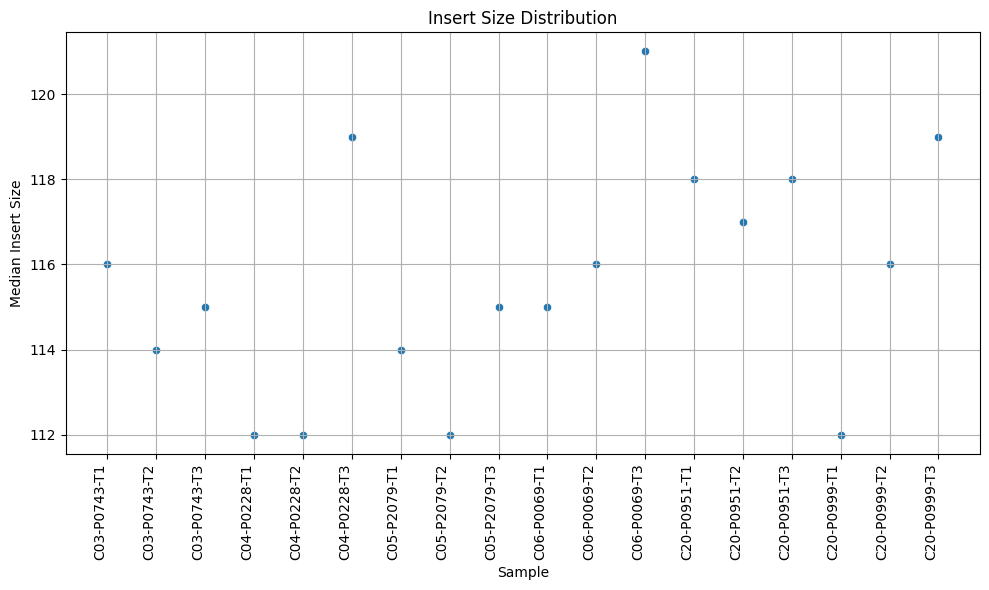

In [56]:
# Load the insert metrics file
insert_metrics = pd.read_csv(os.path.join(base_folder, "multiqc_data/multiqc_picard_insertSize.txt"), sep="\t")

# Create a new 'samples' column by removing the '_sor.*' pattern from the 'Sample' column
insert_metrics['samples'] = insert_metrics['Sample'].apply(lambda x: re.sub(r'_sor.*', '', x))

# Create the scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x='samples', y='MEDIAN_INSERT_SIZE', data=insert_metrics)

# Adjust the X-axis labels format
plt.xticks(rotation=90, ha='right')

# Add labels and a title
plt.xlabel("Sample")
plt.ylabel("Median Insert Size")
plt.title("Insert Size Distribution")

# Display the plot
plt.tight_layout()
plt.grid()
plt.show()


In [ ]:
# Create a DataFrame with samples and their median insert sizes
metrics = pd.DataFrame({
    'samples': insert_metrics['samples'],
    'insert_size': insert_metrics['MEDIAN_INSERT_SIZE']
})

# Calculate the maximum size of the metric
max_metric = metrics.shape[0] + 1

# RNA degradation level

**Purpose of analysis:** RNA degradation is an issue that can affect the quality of sequencing data. 

A high level of degradation is reflected in a higher accumulation of reads towards the 3' end of genes, 

which is a sign that the RNA has been fragmented and the most stable fragments are near the 3' end. This can compromise gene quantification.

**Key data:**
- 3biasIndex: It is calculated as the proportion of reads that fall in the 3' UTR region in relation to all reads mapped to exons. A high value indicates a tendency towards the accumulation of reads at the 3' end of the RNA, which is indicative of degradation.



**Rationale**: The 3' bias index is a good indicator of RNA degradation because degraded RNA tends to break closer to the 5' end, leaving

more 3' end reads. This index is useful for detecting samples with high degradation, which could bias the results of transcriptomic analysis.

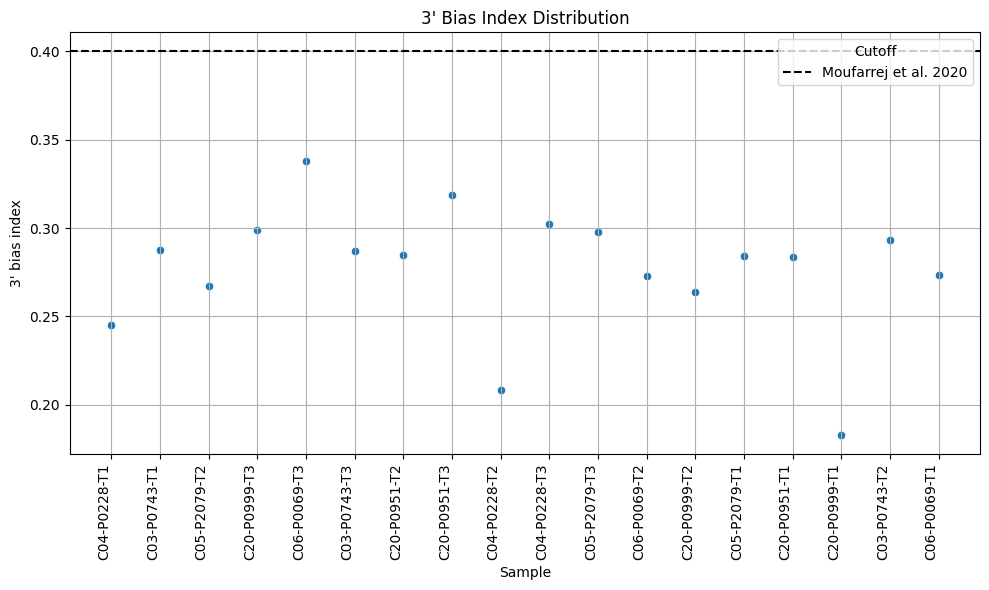

In [ ]:
# Load the metrics file
distribution_metrics = pd.read_csv(os.path.join(base_folder, "3primebias_metrics.txt"), sep="\t")

# Create the scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x='sample', y='biasIndex', data=distribution_metrics)

# Add a horizontal line for the cutoff value
plt.axhline(y=0.4, color='black', linestyle='--', label="Moufarrej et al. 2020")

# Adjust the format of X-axis labels
plt.xticks(rotation=90, ha='right')

# Add labels and a title
plt.xlabel("Sample")
plt.ylabel("3' Bias Index")
plt.title("3' Bias Index Distribution")

# Add a legend manually for the cutoff line
plt.legend(title="Cutoff", loc="upper right")

# Display the plot
plt.tight_layout()
plt.grid()
plt.show()

# DNA contamination

**Purpose of analysis:** DNA contamination is a concern in RNA-seq experiments, as there may be DNA fragments present 

in the samples that should not be there. This contamination is often assessed by looking at the ratio of reads mapping 

to introns versus exons. In RNA-seq, reads should primarily come from exons, as the messenger RNA has been processed to remove introns.

**Key data:**
- introns_tag_count: Number of reads that map to introns.
- allExons: Total number of reads that map to exons (CDS, 5' UTR, 3' UTR).
- intronExonRatio: The ratio of reads mapping to introns to exons. A high ratio indicates possible DNA contamination, as under normal RNA-seq conditions most reads are expected to come from exons.

**Rationale:** Under normal RNA-seq conditions, most reads should map to exons, since introns have been removed from mature messenger RNA. 

If a sample has a high ratio of intronic to exonic reads (intronExonRatio), this suggests that there is contaminating DNA in the sample, because genomic DNA contains introns.

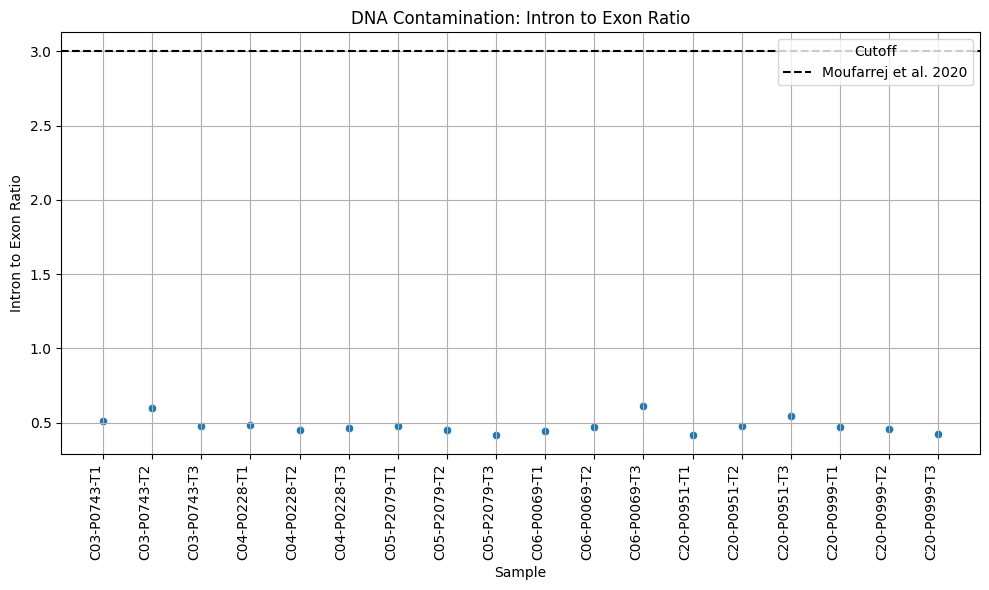

In [58]:
# Read the read distribution metrics file (to evaluate DNA contamination)
distribution_metrics = pd.read_csv(os.path.join(base_folder, "multiqc_data/multiqc_rseqc_read_distribution.txt"), sep="\t")

# Filter samples that contain "RSeQC" in their name
distribution_metrics = distribution_metrics[distribution_metrics['Sample'].str.contains("RSeQC")]

# Extract sample names
distribution_metrics['sample'] = distribution_metrics['Sample'].apply(lambda x: re.sub(r'_RSeQC.*', '', x))

# Calculate necessary columns
distribution_metrics['allExons'] = (
    distribution_metrics['cds_exons_tag_count'] + 
    distribution_metrics['5_utr_exons_tag_count'] + 
    distribution_metrics['3_utr_exons_tag_count']
)

distribution_metrics['biasIndex'] = distribution_metrics['3_utr_exons_tag_count'] / distribution_metrics['allExons']
distribution_metrics['intronExonRatio'] = distribution_metrics['introns_tag_count'] / distribution_metrics['allExons']

# Select relevant columns
distribution_metrics = distribution_metrics[['sample', 'allExons', 'biasIndex', 'intronExonRatio']]

# Create the scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x='sample', y='intronExonRatio', data=distribution_metrics)

# Add a horizontal line for the cutoff value of 3
plt.axhline(y=3, color='black', linestyle='--', label="Moufarrej et al. 2020")

# Adjust the format of X-axis labels
plt.xticks(rotation=90, ha='right')

# Add labels and a title
plt.xlabel("Sample")
plt.ylabel("Intron to Exon Ratio")
plt.title("DNA Contamination: Intron to Exon Ratio")

# Add a legend for the cutoff value
plt.legend(title="Cutoff", loc="upper right")

# Display the plot
plt.tight_layout()
plt.grid()
plt.show()

# Add the 'dna_contamination' column to the 'metrics' DataFrame
#metrics['dna_contamination'] = distribution_metrics['intronExonRatio'].values



# Raw gene counts

In [59]:
# Read the 'biotypes.txt' file delimited by tabs
gtf_database = pd.read_csv("/home/dferri/ipremom/data/DEGs_v45/DEGS_folds/biotypes 1.txt", sep="\t")

# Replace 'NaN' values in the 'gene_name' column with values from the 'gene_ID' column
gtf_database['gene_name'] = gtf_database['gene_name'].fillna(gtf_database['gene_ID'])

# Display the first few records to verify
gtf_database.head()


,gene_ID,gene_type,gene_name
0,ENSG00000210049,Mt_tRNA,MT-TF
1,ENSG00000211459,Mt_rRNA,MT-RNR1
2,ENSG00000210077,Mt_tRNA,MT-TV
3,ENSG00000210082,Mt_rRNA,MT-RNR2
4,ENSG00000209082,Mt_tRNA,MT-TL1


In [60]:
# Select genes of type "protein_coding"
biotype_by_gene_df = (
    dedupCounts
    .reset_index()
    .rename(columns={"GeneID": "gene_name"})[['gene_name']]
    .merge(gtf_database, on="gene_name")
)
biotype_by_gene_df = biotype_by_gene_df[biotype_by_gene_df['gene_type'] == "protein_coding"]

# Filter the dedupCounts matrix to only include "protein_coding" genes
pCoding_matrix = (
    dedupCounts
    .reset_index()
    .rename(columns={"GeneID": "gene_name"})
)
pCoding_matrix = (
    pCoding_matrix[pCoding_matrix['gene_name'].isin(biotype_by_gene_df['gene_name'])]
    .set_index("gene_name")
)

In [61]:
# Apply log2 transformation to the data
log_df = np.log2(dedupCounts + 1)

# Create a DataFrame for boxplot preparation
boxplot_df = pd.DataFrame()
genes = dedupCounts.index

for x in range(len(samples)):
    sample = [samples[x]] * len(log_df)  # Repeat the sample name for all genes
    log_counts = log_df.iloc[:, x].values  # Log-transformed counts for the sample
    group_bx = [metadataDF['group'].iloc[x]] * len(log_df)  # Group information for the sample
    run_bx = [run[x]] * len(log_df)  # Run information for the sample
    tmp = pd.DataFrame({
        'genes': genes,
        'sample': sample,
        'logCounts': log_counts,
        'group_bx': group_bx,
        'run_bx': run_bx
    })
    boxplot_df = pd.concat([boxplot_df, tmp], ignore_index=True)

# Replace 'Si' with 'PE' in the group_bx column
boxplot_df['group_bx'] = boxplot_df['group_bx'].replace('Si', 'PE')

# Display the prepared DataFrame
boxplot_df


,genes,sample,logCounts,group_bx,run_bx
0,DDX11L2,C20-P0999-T2,2.807355,PE,MOM-32
1,DDX11L1,C20-P0999-T2,0.000000,PE,MOM-32
2,WASH7P,C20-P0999-T2,2.584963,PE,MOM-32
3,MIR6859-1,C20-P0999-T2,0.000000,PE,MOM-32
4,MIR1302-2HG,C20-P0999-T2,1.000000,PE,MOM-32
...,...,...,...,...,...
1109101,ENSG00000276312,C06-P0069-T2,0.000000,PE,MOM-32
1109102,ENSG00000278573,C06-P0069-T2,0.000000,PE,MOM-32
1109103,ENSG00000276017,C06-P0069-T2,2.000000,PE,MOM-32
1109104,ENSG00000278817,C06-P0069-T2,0.000000,PE,MOM-32


In [62]:
boxplot_df.group_bx.value_counts()

PE         924255
Control    184851
Name: group_bx, dtype: int64

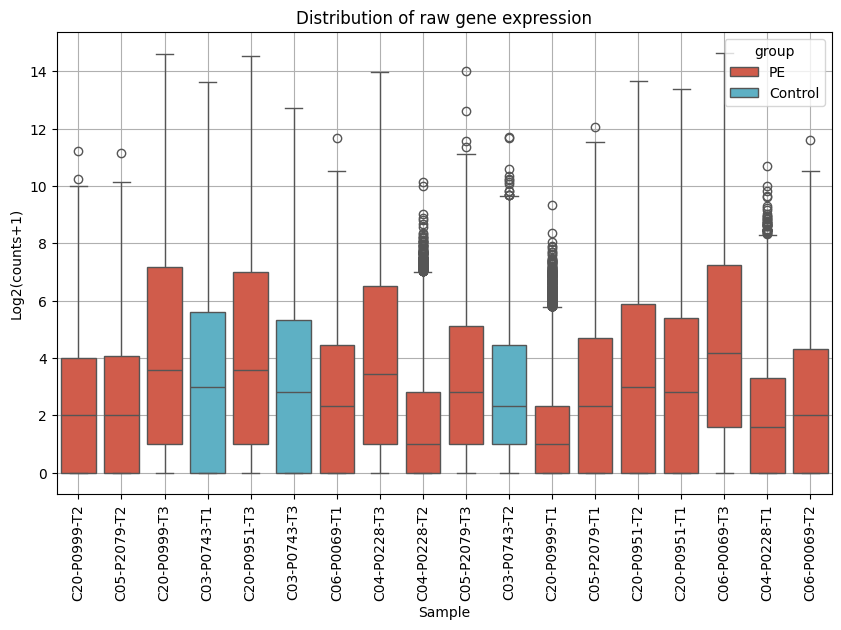

In [63]:
# create the boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x='sample', y='logCounts', hue='group_bx', data=boxplot_df, palette={"PE": "#E64B35FF", "Control": "#4DBBD5FF"})
plt.xticks(rotation=90)
plt.xlabel("Sample")
plt.ylabel("Log2(counts+1)")
plt.title("Distribution of raw gene expression")
plt.legend(title="group")
plt.grid()
plt.show()


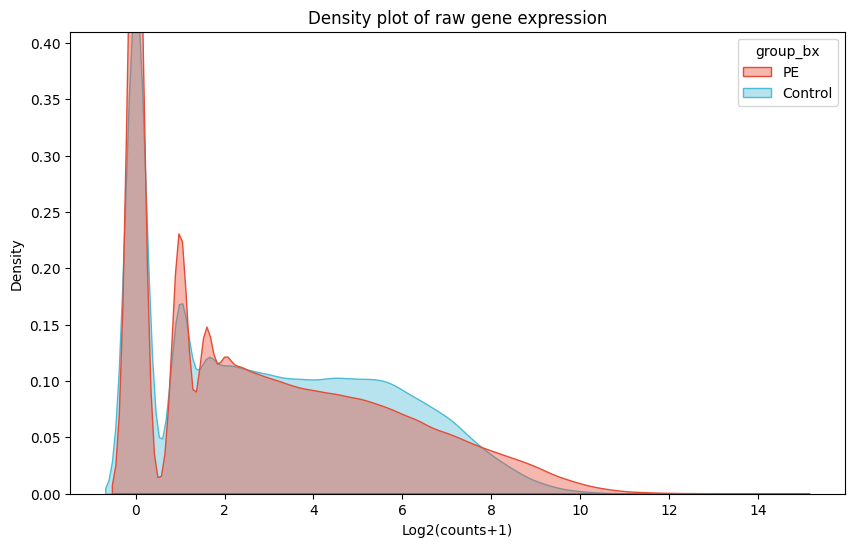

In [64]:
# create density figure
plt.figure(figsize=(10, 6))
sns.kdeplot(data=boxplot_df, x='logCounts', hue='group_bx', fill=True, common_norm=False, alpha=0.4, palette={"PE": "#E64B35FF", "Control": "#4DBBD5FF"})
plt.ylim(None, 0.41)
plt.xlabel("Log2(counts+1)")
plt.title("Density plot of raw gene expression")
plt.show()


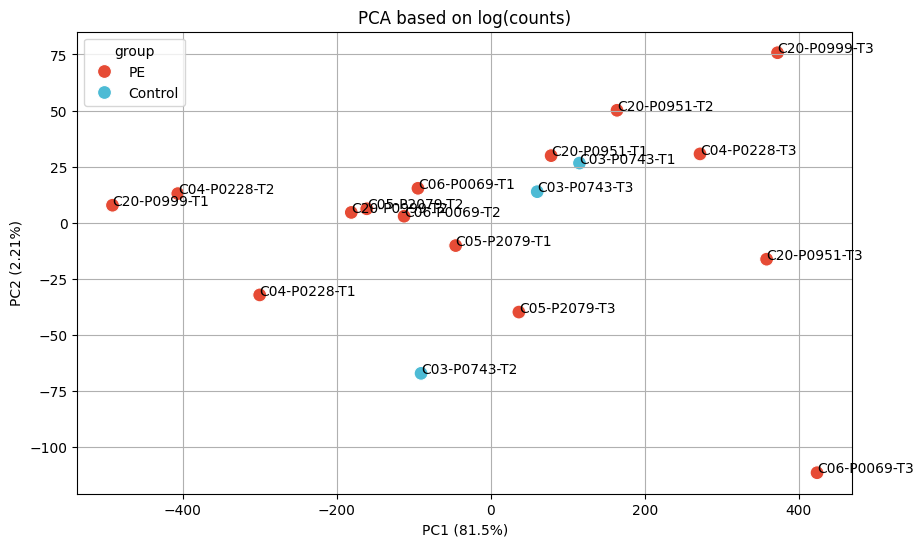

In [65]:
# apply pca
pca = PCA(n_components=2)
pca_result = pca.fit_transform(log_df.T)

# Ccreate a df with pca data
pcamat1 = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])
pcamat1['sample'] = log_df.columns

# combine with metadata
metadataDF['group'] = metadataDF['group'].replace('Si', 'PE')
pcamat2 = pcamat1.merge(metadataDF, on="sample")

# compute the explained std
var_exp = np.round(pca.explained_variance_ratio_ * 100, 2)

# create the pca plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PC1', y='PC2', hue='group', data=pcamat2, palette={"PE": "#E64B35FF", "Control": "#4DBBD5FF"}, s=100)
plt.xlabel(f"PC1 ({var_exp[0]}%)")
plt.ylabel(f"PC2 ({var_exp[1]}%)")
plt.title("PCA based on log(counts)")

# add labels to points
for i in range(pcamat2.shape[0]):
    plt.text(pcamat2['PC1'][i], pcamat2['PC2'][i], pcamat2['sample'][i])

plt.grid()
plt.show()


# Normalized gene counts

In [66]:
path_norm_data = "/home/dferri/ipremom/reports/report_MOMX/DATA/MOM-32/normalized_data"
norm_data = os.listdir(path_norm_data)
norm_data

['cpm_TMM.csv', 'pm_dge_counts.csv', 'cpm_logTMM.csv', 'pm_dge_samples.csv']

In [67]:
cpm_TMM = pd.read_csv(path_norm_data + "/cpm_TMM.csv", index_col = 0)
cpm_logTMM = pd.read_csv(path_norm_data + "/cpm_logTMM.csv", index_col = 0)

pm_dge_counts = pd.read_csv(path_norm_data + "/pm_dge_counts.csv", index_col = 0)
pm_dge_samples = pd.read_csv(path_norm_data + "/pm_dge_samples.csv", index_col = 0)

cpm_TMM.shape, cpm_logTMM.shape, pm_dge_counts.shape, pm_dge_samples.shape

((36532, 18), (36532, 18), (36532, 18), (18, 12))

In [68]:
fCounts = pm_dge_counts

boxplot_df = pd.DataFrame()
genes = cpm_logTMM.index

for x in range(len(pm_dge_samples)):
    sample = [pm_dge_samples.index[x]] * len(cpm_logTMM)
    logTMM = cpm_logTMM.iloc[:, x].values
    group_bx = [pm_dge_samples['group'][x]] * len(cpm_logTMM)
    tmp = pd.DataFrame({
        'genes': genes,
        'sample': sample,
        'logTMM': logTMM,
        'group_bx': group_bx
    })
    boxplot_df = pd.concat([boxplot_df, tmp], ignore_index=True)


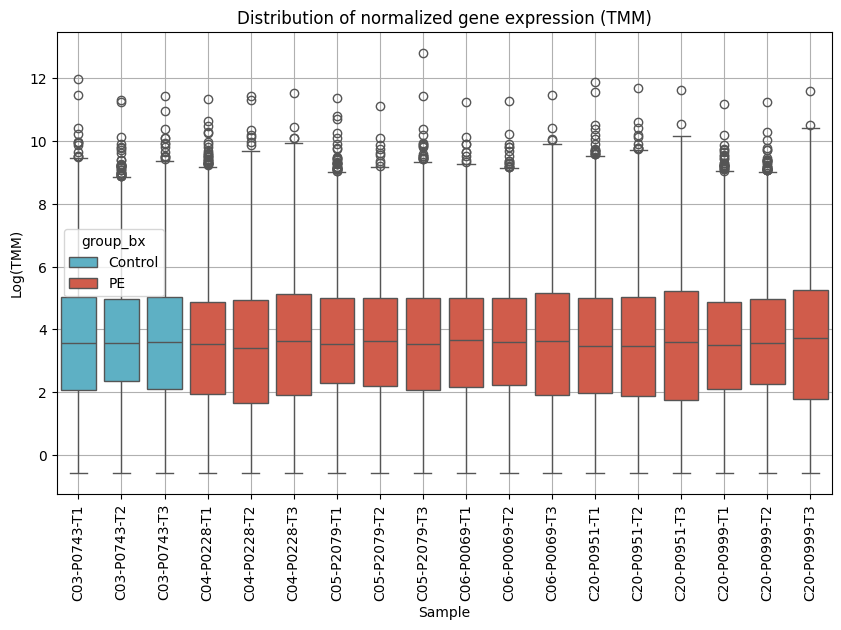

In [69]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='sample', y='logTMM', hue='group_bx', data=boxplot_df, palette={"PE": "#E64B35FF", "Control": "#4DBBD5FF"})
plt.xticks(rotation=90)
plt.xlabel("Sample")
plt.ylabel("Log(TMM)")
plt.title("Distribution of normalized gene expression (TMM)")
plt.grid()
plt.show()


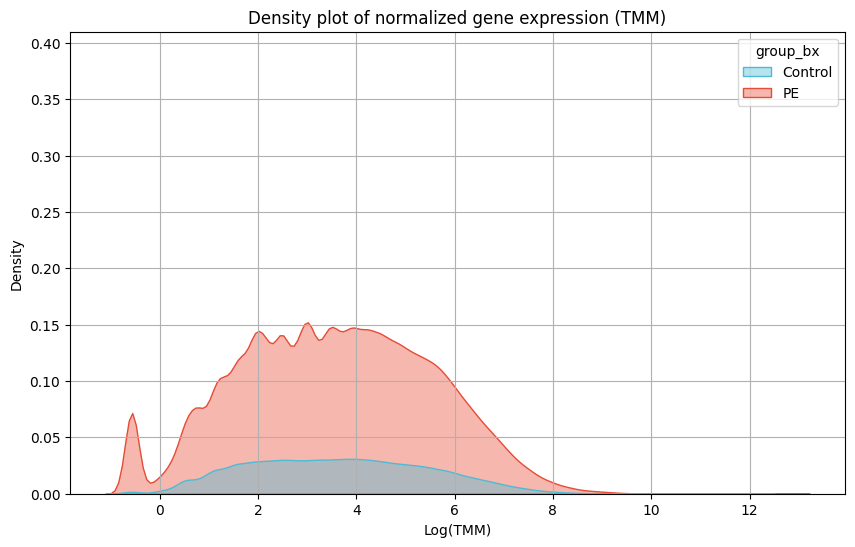

In [70]:
plt.figure(figsize=(10, 6))
sns.kdeplot(data=boxplot_df, x='logTMM', hue='group_bx', fill=True, alpha=0.4, palette={"PE": "#E64B35FF", "Control": "#4DBBD5FF"})
plt.ylim(None, 0.41)
plt.xlabel("Log(TMM)")
plt.title("Density plot of normalized gene expression (TMM)")
plt.grid()
plt.show()

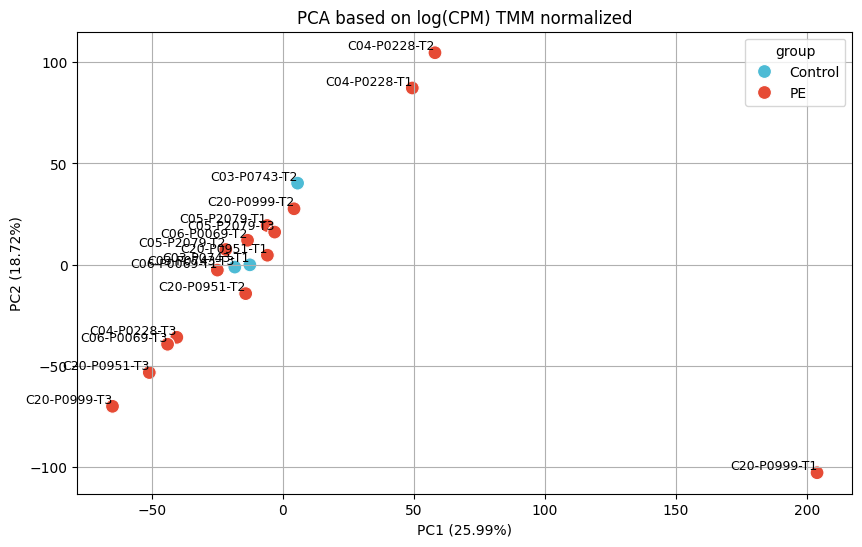

In [71]:
# Aplicar PCA a los datos log-transformados
pca = PCA(n_components=2)
pca_result = pca.fit_transform(cpm_logTMM.T)

# Crear un DataFrame con los resultados del PCA
pcamat1 = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])
pcamat1['sample'] = cpm_logTMM.columns

# Combinar con los metadatos
pcamat2 = pcamat1.merge(pm_dge_samples, left_on='sample', right_index=True)

# Calcular la varianza explicada
var_exp = np.round(pca.explained_variance_ratio_ * 100, 2)

# Crear el gráfico PCA
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PC1', y='PC2', hue='group', data=pcamat2, palette={"PE": "#E64B35FF", "Control": "#4DBBD5FF"}, s=100)

# Añadir etiquetas a los puntos
for i in range(pcamat2.shape[0]):
    plt.text(pcamat2['PC1'][i], pcamat2['PC2'][i], pcamat2['sample'][i], 
             fontsize=9, verticalalignment='bottom', horizontalalignment='right')

# Ajustar etiquetas y mostrar el gráfico
plt.xlabel(f"PC1 ({var_exp[0]}%)")
plt.ylabel(f"PC2 ({var_exp[1]}%)")
plt.title("PCA based on log(CPM) TMM normalized")
plt.grid()
plt.show()



### READ FROM CM, FOR PLOT ALL JOINT DATA (EOPE or LOPE - Tn WITH CONTROLS)

In [72]:
samples_run = [x.split("-")[0] + "-" + x.split("-")[1] for x in cpm_logTMM.T.index]
samples_run

['C03-P0743',
 'C03-P0743',
 'C03-P0743',
 'C04-P0228',
 'C04-P0228',
 'C04-P0228',
 'C05-P2079',
 'C05-P2079',
 'C05-P2079',
 'C06-P0069',
 'C06-P0069',
 'C06-P0069',
 'C20-P0951',
 'C20-P0951',
 'C20-P0951',
 'C20-P0999',
 'C20-P0999',
 'C20-P0999']

In [73]:
df = pd.read_csv("/home/dferri/ipremom/model/v45/data/counts_matrix/new/limma_counts_normal_lope_ctr_t3_not_hb 4.csv", index_col = 0).T
df.head()

,DDX11L2,WASH7P,OR4F5,ENSG00000238009,ENSG00000269981,DDX11L17,WASH9P,MTATP6P1,ENSG00000291215,LINC01409,...,ENSG00000271254,ENSG00000277475,ENSG00000277856,ENSG00000275063,ENSG00000278673,ENSG00000273554,ENSG00000277836,ENSG00000278633,ENSG00000276017,ENSG00000277196
C02-P0013-T3,3.253888,2.251209,1.372264,1.596065,1.789765,2.963787,2.600281,2.251209,3.749430,4.153248,...,7.114359,1.789765,2.881132,4.153248,3.318135,1.372264,1.372264,3.653083,1.960510,0.362368
C02-P0016-T3,3.595521,2.625852,1.408750,2.468051,2.733818,3.774732,3.978694,0.460490,3.496812,3.455356,...,7.826361,2.382167,1.408750,0.891930,3.228071,2.987539,1.788470,4.427688,3.276483,2.587990
C02-P0039-T3,2.726502,2.657274,0.728633,0.976112,1.371467,3.494393,3.494393,1.187290,2.792559,3.533552,...,7.844753,2.048857,1.681455,2.250342,2.427106,-1.262873,1.187290,1.187290,2.792559,2.048857
C03-P0007-T3,4.290965,2.579879,2.579879,3.528706,2.969557,3.675490,3.675490,2.969557,3.276052,3.808710,...,8.092565,2.721792,1.183184,2.721792,3.180943,1.810161,-1.262873,3.808710,3.180943,2.721792
C03-P0008-T3,3.491932,2.043711,-1.262873,1.089043,1.828974,4.058971,4.034080,2.544402,3.118474,3.416895,...,7.569931,2.140173,1.708293,2.140173,3.563258,1.431641,0.347123,4.034080,3.817791,1.828974


In [74]:
df.shape

(74, 29303)

In [75]:
CONTROL = [
    "C02-P0039", "C03-P0708", "C03-P0757", "C03-P0807", "C05-P0002",
    "C05-P0050", "C05-P0066", "C05-P0132", "C05-P0166", "C05-P0237",
    "C05-P0260", "C05-P0375", "C05-P0987", "C05-P1665", "C05-P1671",
    "C05-P1682", "C05-P1718", "C05-P1728", "C05-P1736", "C09-P0015",
    "C09-P0153", "C10-P0014", "C10-P0015", "C12-P0012", "C12-P0078",
    "C12-P0110", "C12-P0210", "C12-P0232", "C12-P0419", "C12-P0440",
    "C20-P0176", "C20-P0638", "C20-P0646", "C20-P0654", "C20-P0698",
    "C20-P1178", "C05-P1759", "C12-P0552", "C05-P2099", "C03-P0743",
    "C03-P0026", "C03-P0045", "C02-P0013", "C03-P0007", "C03-P0024",
    "C03-P0037", "C03-P0046", "C03-P0047", "C03-P0157", "C03-P0168",
    "C03-P0205", "C05-P0010", "C05-P0253", "C09-P0010", "C09-P0100",
    "C09-P0228", "C09-P0237", "C09-P0712", "C12-P0043", "C12-P0051",
    "C12-P0108", "C12-P0209", "C12-P0295", "C12-P0373", "C20-P0797",
    "C20-P0183", "C03-P0008", "C12-P0122", "C05-P0725", "C05-P0045",
    "C06-P0019", "C03-P0447", "C05-P0847", "C12-P0090", "C12-P0314"
]

LOPE = [
    "C02-P0016", "C03-P0039", "C03-P0044", "C03-P0052", "C03-P0129", 
    "C03-P0131", "C03-P0239", "C03-P0632", "C03-P0768", "C03-P0779", 
    "C04-P0106", "C05-P0305", "C05-P0447", "C06-P0064", "C09-P0246", 
    "C09-P0400", "C09-P0405", "C09-P0465", "C09-P0857", "C09-P0858", 
    "C09-P0891", "C09-P0940", "C09-P0941", "C11-P0025", "C12-P0049", 
    "C12-P0164", "C12-P0182", "C12-P0324", "C12-P0348", "C12-P0538", 
    "C20-P0317", "C20-P0528", "C20-P0864", "C20-P1003", "C20-P1094", 
    "C21-P0197", "C21-P0600", "C12-P0231", "C05-P1379", "C12-P0447", 
    "C20-P0815", "C21-P0583", "C21-P1237"
]

EOPE = [
    "C03-P0041", "C03-P0190", "C03-P0290", "C03-P0356", "C03-P0428",
    "C03-P0470", "C03-P0592", "C03-P0702", "C03-P0911", "C04-P0118",
    "C04-P0189", "C05-P0151", "C05-P0699", "C05-P0940", "C09-P0082",
    "C09-P0329", "C09-P0649", "C09-P0798", "C09-P0950", "C09-P1069",
    "C10-P0130", "C11-P0039", "C12-P0033", "C12-P0067", "C12-P0114",
    "C12-P0323", "C12-P0520", "C20-P0126", "C20-P0144", "C20-P0302",
    "C20-P0534", "C21-P0447", "C21-P0849", "C21-P0867", "C21-P0962",
    "C21-P0890", "C05-P2079", "C04-P0228", "C20-P0951", "C04-P0412", 
    "C20-P0999", "C06-P0069"
]


df = pd.read_csv("/home/dferri/ipremom/model/v45/data/counts_matrix/new/limma_counts_normal_/limma_counts_normal_lope_ctr_t2_not_hb 1.csv", index_col = 0).T


# remove "Tn" from samples
df.index = df.index.str.replace(r'-T2$', '', regex=True)

# filter by OE and C
df_eope = df[df.index.isin(LOPE)]
df_control = df[df.index.isin(CONTROL)]

# Combvine both
df_pca = pd.concat([df_eope, df_control])

print(df_pca.shape, df_eope.shape, df_control.shape)
len(CONTROL), len(EOPE), len(LOPE)

(117, 31290) (42, 31290) (75, 31290)


(75, 42, 43)

In [76]:
# get oca data
X = df_pca.values
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X)

# create df with pca data and samples info
pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'], index=df_pca.index)
pca_df['Group'] = ['LOPE' if sample in LOPE else 'Control' for sample in pca_df.index]

pca_df.Group.value_counts()

Control    75
LOPE       42
Name: Group, dtype: int64

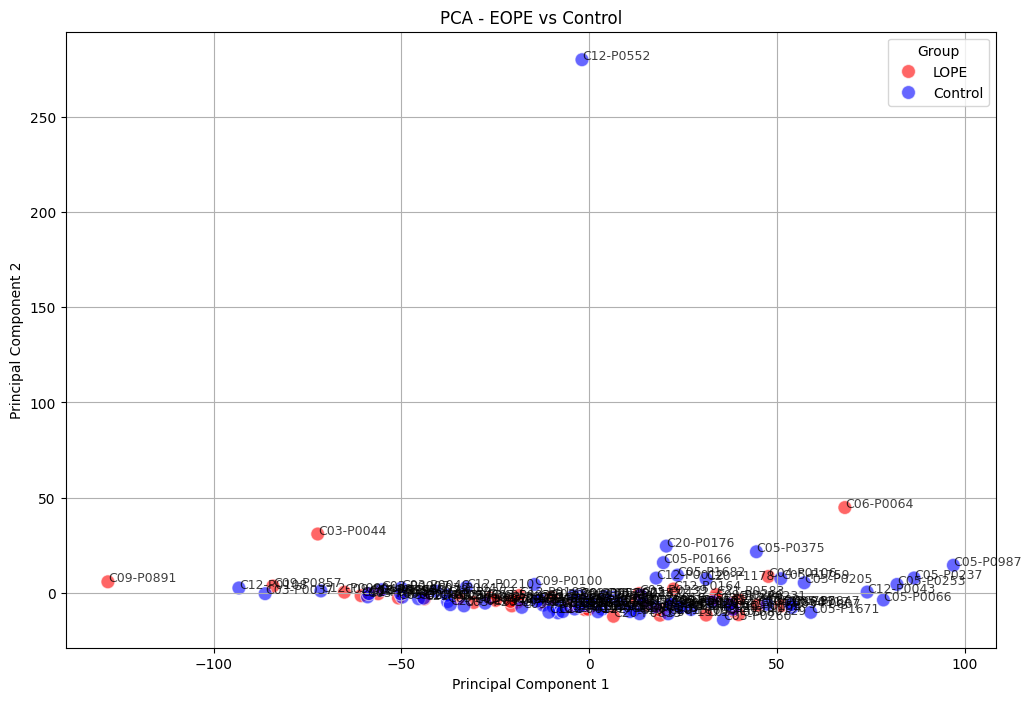

In [77]:
# plot PCA
plt.figure(figsize=(12, 8))
sns.scatterplot(x='PC1', y='PC2', hue='Group', data=pca_df, palette={'LOPE': 'r', 'Control': 'b'}, s=100, alpha=0.6)
plt.title("PCA - EOPE vs Control")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Group")
plt.grid(True)

# add name for each sample
for i, sample in enumerate(pca_df.index):
    plt.text(pca_df['PC1'][i] + 0.02, pca_df['PC2'][i], sample, fontsize=9, alpha=0.75)

plt.show()



In [34]:
pca_df.to_csv("pca_LOPE_CONTROL_T2.csv")

In [39]:
pca_df.loc["C12-P0552"]

PC1       -1.880479
PC2      280.040756
Group       Control
Name: C12-P0552, dtype: object